In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings

sns.set()
rcParams['figure.figsize'] = (20,10)
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')
from pprint import pprint
import json

from transformers import AutoTokenizer, AutoModel, AutoConfig, pipeline
from datasets import load_dataset, Dataset, concatenate_datasets

In [2]:
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-3b")

### CNN_DAILY

In [ ]:
cnn = Dataset.from_json('../../data/translated/cnn_dailymail_30k_samples_len_100_1200_words_translated.json')

In [ ]:
input_template="Tóm tắt ngắn gọn đoạn văn bản sau đây:\n{article_translated}\nĐoạn văn bản đã được tóm tắt:\n"
def mapper(x):
    return {
        'input': input_template.format(article_translated=x['article_translated']),
        'output': x['highlights_translated']
    }

temp_cnn = cnn.shuffle().select(range(15000)).map(mapper,batched=False, remove_columns=['article_translated','highlights_translated'])

In [ ]:
temp_cnn

In [ ]:
print(temp_cnn[0]['input'] + temp_cnn[0]['output'])

In [ ]:
length = temp_cnn.shuffle().select(range(1000)).map(lambda x: {'len':len(tokenizer.tokenize(x['input'] + x['output']))})

In [ ]:
length.to_pandas().hist(bins=100)

In [ ]:
temp_cnn.to_json('../../data/training_2_8/cnn_15k_samples.jsonl', orient='records', lines=True)

In [ ]:
temp_cnn[0]

### DIALOG SUMMARY

In [ ]:
dialog = Dataset.from_json('../../data/translated/dialogsum_10k_samples_len_50_words_translated.json')

In [ ]:
dialog

In [ ]:
input_template="Tóm tắt ngắn gọn đoạn hội thoại sau đây:\n{dialogue_translated}\nĐoạn hội thoại đã được tóm tắt:\n"
def mapper(x):
    return {
        'input': input_template.format(dialogue_translated=x['dialogue_translated']),
        'output': x['summary_translated']
    }

temp_dialog = dialog.shuffle().select(range(10000)).map(mapper,batched=False, remove_columns=['dialogue_translated','summary_translated'])

In [ ]:
temp_dialog.to_json('../../data/training_2_8/dialogsum_10k_samples.jsonl', orient='records', lines=True)

### FAQS

In [22]:
faqs = Dataset.from_json('../../data/training_31_7/faq_chat_10k.jsonl')

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-e90f1f489bc5a6e2/0.0.0)


In [24]:
print(faqs.shuffle()[0]['input'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Trả lời câu hỏi pháp luật dựa vào những điều luật liên quan dưới đây. Chỉ được trả lời dựa trên điều luật được cung cấp. Nếu không đủ thông tin để trả lời thì trả lời: Tôi không biết.
Câu hỏi: Việc bán phần tài sản kê biên của người phải thi hành án cho sở hữu chung như thế nào? Hồ sơ đề nghị cấp quyền sở hữu, sử dụng cho người mua phần tài sản của người phải thi hành án gồm những gì?
Điều luật liên quan: Điều 7. Việc mua tài sản thuộc sở hữu chung; giao, nhận tài sản để trừ vào số tiền được thi hành án 1. Trường hợp chủ sở hữu chung mua tài sản kê biên; người được thi hành án đồng ý nhận tài sản để trừ vào số tiền được thi hành án thì thực hiện như sau: a) Đối với tài sản là bất động sản và động sản phải đăng ký quyền sở hữu, quyền sử dụng. Chấp hành viên ra quyết định bán tài sản cho chủ sở hữu chung hoặc ra quyết định giao tài sản cho người được thi hành án. b) Đối với tài sản là động sản nhưng không phải đăng ký quyền sở hữ

In [ ]:
text = 'Cuộc trò chuyện giữa con người và trợ lý AI.\n'
def mapper(x):
    return {
        'input': text,
        'output': x['input'].removeprefix(text),
    }

temp_faqs = faqs.map(mapper, batched=False)

In [ ]:
temp_faqs[0]

In [ ]:
temp_faqs.to_json('../../data/training_2_8/faqs.jsonl', orient='records', lines=True)

### SHARE_GPT

In [ ]:
share = Dataset.from_json('../../data/translated/share_gpt_no_code_conversations_40k_translated.json')

In [ ]:
share = share.filter(lambda x: len(tokenizer.tokenize(x["input"])) < 2000)

In [ ]:
print(share.shuffle()[0]['input'])

In [ ]:
share.shuffle().select(range(1000)).map(lambda x: {'len':len(tokenizer.tokenize(x['input']))}).to_pandas().hist(bins=100)

In [ ]:
share[0]['output'].removeprefix('Cuộc trò chuyện giữa con người và trợ lý AI.\n')

In [ ]:
text = 'Cuộc trò chuyện giữa con người và trợ lý AI.\n'
def mapper(x):
    return {
        'input': text,
        'output': x['output'].removeprefix(text),
    }

share = share.map(mapper, batched=False)

In [ ]:
share.to_json('../../data/training_2_8/share_gpt_2k_tokens.jsonl', orient='records', lines=True)

### QUORA

In [ ]:
quora = Dataset.from_json('../../data/translated/quora_chat_data_translated.json')

In [ ]:
print(quora.shuffle()[0]['prompt'])

In [ ]:
quora.shuffle().select(range(1000)).map(lambda x: {'len':len(tokenizer.tokenize(x['prompt']))}).to_pandas().hist(bins=100)

In [ ]:
temp_quora = quora.shuffle().select(range(15000))
temp_quora

In [ ]:
text = 'Cuộc trò chuyện giữa con người và trợ lý AI.\n'
def mapper(x):
    return {
        'input': text,
        'output': x['prompt'].removeprefix(text),
    }

temp_quora = temp_quora.map(mapper, batched=False)

In [ ]:
temp_quora.to_json('../../data/training_2_8/quora_15k_samples.jsonl', orient='records', lines=True)

### OASST

In [3]:
en_oasst = Dataset.from_json('../../data/translated/en_oasst_translated.json')
en_oasst = en_oasst.rename_column('text_translated','text')
vi_oasst = Dataset.from_json('../../data/original/oasst/vi_oasst.json')

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-09fbf7801d1ca68d/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-3b9d00815d262c03/0.0.0)


In [4]:
oasst = concatenate_datasets([en_oasst,vi_oasst],axis=0)
oasst

Dataset({
    features: ['text'],
    num_rows: 21293
})

{'text': 'Cuộc trò chuyện giữa con người và trợ lý AI.\n[|Con người|] Bạn có thể viết một đoạn giới thiệu ngắn về sự liên quan của thuật ngữ "độc quyền mua bán" trong kinh tế học không? Vui lòng sử dụng các ví dụ liên quan đến độc quyền tiềm năng trong thị trường lao động và trích dẫn nghiên cứu có liên quan.\n[|AI|] "Độc quyền" là cấu trúc thị trường chỉ có một người mua đối với một hàng hóa hoặc dịch vụ cụ thể. Trong kinh tế học, thuật ngữ này đặc biệt phù hợp trong thị trường lao động, nơi người sử dụng lao động độc quyền có quyền lực đáng kể đối với tiền lương và điều kiện làm việc của nhân viên của họ. Sự hiện diện của độc quyền có thể dẫn đến tiền lương thấp hơn và giảm cơ hội việc làm cho người lao động, vì người sử dụng lao động có ít động lực để tăng lương hoặc cung cấp điều kiện làm việc tốt hơn.\n\nNghiên cứu gần đây đã xác định các công ty độc quyền tiềm năng trong các ngành như bán lẻ và thức ăn nhanh, nơi một số công ty lớn kiểm soát một phần đáng kể thị trường (Bivens & 

In [5]:
text = 'Cuộc trò chuyện giữa con người và trợ lý AI.\n'
def mapper(x):
    return {
        'input': text,
        'output': x['text'].removeprefix(text),
    }

temp_oasst = oasst.map(mapper, batched=False, remove_columns=['text'])

Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-09fbf7801d1ca68d/0.0.0/cache-f811f5d23048376d.arrow


In [6]:
temp_oasst

Dataset({
    features: ['input', 'output'],
    num_rows: 21293
})

In [ ]:
temp_oasst.to_json('../../data/training_2_8/oasst_21k_samples.jsonl', orient='records', lines=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

array([[<AxesSubplot:title={'center':'len'}>]], dtype=object)

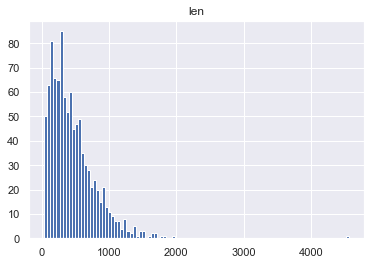

In [7]:
oasst.shuffle().select(range(1000)).map(lambda x: {'len':len(tokenizer.tokenize(x['text']))}).to_pandas().hist(bins=100)

In [20]:
print(oasst.shuffle()[0]['text'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] f5 là gì
[|AI|] F5 là công ty công nghệ mạng chuyên về công nghệ mạng phân phối ứng dụng, chẳng hạn như cân bằng tải, bảo mật và tối ưu hóa hiệu suất. Các sản phẩm của F5 giúp các tổ chức đảm bảo các ứng dụng của họ luôn khả dụng, nhanh chóng và an toàn.

Nó cũng có thể ám chỉ đến Fast and Furious Five, phần thứ năm trong loạt phim The Fast and the Furious, trong đó Vin Diesel và Paul Walker quá cố đảm nhận lại vai trò của họ là Dominic Toretto và Brian O'Connor. Họ phát hiện ra một âm mưu liên quan đến một tổ chức tội phạm sử dụng hệ thống máy tính công nghệ cao để chiếm đoạt và kiểm soát phần cứng quân sự. Tách ra, họ chiến đấu với bọn tội phạm và cuối cùng hạ gục thủ lĩnh của chúng. Gia đình.

Nó cũng là một phím trên bàn phím của bạn, thường được gắn nhãn F5 hoặc Fn+F5, thường được sử dụng để làm mới hoặc tải lại trang web hoặc tài liệu. Các mục đích sử dụng khác bao gồm khởi động lại chương trình hoặc bật/tắt WiFi của máy 

In [21]:
oasst.to_json('../../data/translated/oasst_translated.json')

Creating json from Arrow format:   0%|          | 0/22 [00:00<?, ?ba/s]

73347770

### ALPACA CHAT

In [ ]:
alpaca = Dataset.from_json('../../data/training_31_7/alpaca_chat_15k.jsonl')
alpaca

In [ ]:
text = 'Cuộc trò chuyện giữa con người và trợ lý AI.\n'
def mapper(x):
    return {
        'input': text,
        'output': x['input'].removeprefix(text),
    }

temp_alpaca = alpaca.map(mapper, batched=False, remove_columns=['input'])

In [ ]:
temp_alpaca[0]

In [ ]:
temp_alpaca.to_json('../../data/training_2_8/alpaca_chat_15k_samples.jsonl', orient='records', lines=True)

### GPT4 INSTRUCT

In [291]:
gpt4 = Dataset.from_json('../../data/translated/gpt4_instruct_similarity_0_9_translated.json')
gpt4

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-3973f66dcdf3ca58/0.0.0)


Dataset({
    features: ['instruction_translated', 'input_translated', 'response_translated'],
    num_rows: 17873
})

In [333]:
template1 = "Dưới đây là mô tả về một yêu cầu, kèm theo một đầu vào cho yêu cầu đó. Hãy đưa ra câu trả lời phù hợp với yêu cầu.\nYêu cầu:\n{instruction_translated}\nĐầu vào:\n{input_translated}\nCầu trả lời:\n"
template2 = "Dưới đây là mô tả về một yêu cầu. Hãy đưa ra câu trả lời phù hợp với yêu cầu.\nYêu cầu:\n{instruction_translated}\nCầu trả lời:\n"

def mapper(x):
    if x['input_translated'] != '' and x['input_translated'] is not None:
        template = template1.format(
            instruction_translated=x['instruction_translated'], 
            input_translated=x['input_translated']
        )
    else:
        template = template2.format(instruction_translated=x['instruction_translated'])
    return {
        'input': template,
        'output': x['response_translated']
    }

temp_gpt4 = gpt4.map(mapper,batched=False, remove_columns=gpt4.column_names)

Map:   0%|          | 0/17873 [00:00<?, ? examples/s]

In [340]:
temp_gpt4

Dataset({
    features: ['input', 'output'],
    num_rows: 17873
})

In [437]:
a = temp_gpt4.shuffle()[0]
print(a['input']+a['output'])

Dưới đây là mô tả về một yêu cầu, kèm theo một đầu vào cho yêu cầu đó. Hãy đưa ra câu trả lời phù hợp với yêu cầu.
Yêu cầu:
Dựa trên thông tin đã cho, đề xuất mẫu xe tốt nhất cho khách hàng.
Đầu vào:
Hồ sơ khách hàng: Gia đình 4 người, đi làm 15 dặm hàng ngày, có ý thức bảo vệ môi trường, thích xe hơi tiết kiệm nhiên liệu và có ngân sách $35.000.
Cầu trả lời:
Xem xét quy mô gia đình, việc đi lại hàng ngày, các mối quan tâm về môi trường, ưu tiên tiết kiệm nhiên liệu và ngân sách, tôi muốn giới thiệu một chiếc xe hybrid chẳng hạn như Toyota Prius. Mẫu xe này mang lại sự cân bằng giữa hiệu suất nhiên liệu, khả năng chi trả và không gian cho một gia đình bốn người.


In [438]:
temp_gpt4.to_json('../../data/training_2_8/gpt4_instruct.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/18 [00:00<?, ?ba/s]

29405688

In [528]:
from glob import glob
def load_dataset(folder_path, dataset_size=None):
    data = []
    for path in glob(folder_path + "/*.jsonl"):
        ds = Dataset.from_json(path)
        for check in ['input', 'output']:
            if check not in ds.column_names:
                raise ValueError("Dataset must have input, output columns")
        # take only the input and output columns
        ds = ds.select_columns(['input', 'output'])
        data.append(ds)
    if dataset_size is None:
        return concatenate_datasets(data, axis=0).shuffle(seed=42)
    return (
        concatenate_datasets(data, axis=0).shuffle(seed=42).select(range(dataset_size))
    )

def clean(ds):
    def mapper(x):
        for column in ds.column_names:
            x[column] = x[column].replace('[|Human|]','[|Con người|]')
        return x
    def filter(x):
        for column in ds.column_names:
            if x[column] == '' or x[column] is None:
                return False
        return True

    new_ds = ds.map(mapper,batched=False)
    new_ds = new_ds.filter(filter)
    return new_ds        

In [529]:
ds = load_dataset('../../data/training_2_8')
ds = clean(ds)

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-f98428edfa869424/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-ed1c46715fa633b6/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-8f6ba5c753f41139/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-81f50c62a3dafb9a/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-4dcf8fe6e0bf3db6/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-3479b7e1d603347c/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-27e07d763f4a0b21/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-4e1805ae55f877e8/0.0.0)
Loading cached shuffled indices for dataset at /Users/phamhoang1408/.cache/huggingface/datasets/

In [569]:
a = ds.shuffle()[0]
print(a['input'] + a['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Điều gì xảy ra nếu tôi giữ một tờ giấy theo chiều ngang bằng hai tay và tôi buông một tay?
[|AI|] Nếu bạn giữ một tờ giấy theo chiều ngang bằng hai tay và buông một tay ra, tờ giấy sẽ bắt đầu nghiêng về phía tay buông. Mức độ nghiêng phụ thuộc vào góc mà tờ giấy được giữ và lực tác dụng của tay còn lại.

Nếu giấy được giữ ở một góc tương đối bằng phẳng, nó có thể giữ nguyên trong một thời gian ngắn trước khi trọng lực chiếm ưu thế và giấy bắt đầu nghiêng. Khi nó nghiêng, sự phân bổ trọng lượng của giấy sẽ thay đổi, khiến nó ngày càng trở nên không ổn định. Nếu góc nghiêng đủ dốc, tờ giấy cuối cùng sẽ rơi xuống đất.

Trong một số trường hợp, bạn có thể nhanh chóng lấy tờ giấy bằng tay kia để ngăn tờ giấy rơi xuống. Tuy nhiên, điều này phụ thuộc vào tốc độ phản ứng của bạn và khoảng cách của tay kia với tờ giấy.

Nhìn chung, kết quả của việc buông một tay khi đang giữ một tờ giấy theo chiều ngang sẽ phụ thuộc vào một số yếu tố, c

In [571]:
ds.to_json('../../data/training_2_8/all_2_8.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/120 [00:00<?, ?ba/s]

521947314

In [663]:
ds.shuffle()[0]

{'input': 'Tóm tắt ngắn gọn đoạn hội thoại sau đây:\n[|Con người|] Chào buổi tối, thưa ông. Tôi có thể làm gì cho bạn?\n[|AI|] Bourbon, làm ơn.\n[|Con người|] Bạn muốn rượu Bourbon của mình như thế nào, uống thẳng hay uống trên đá?\n[|AI|] Cho nước đá vào nhé.\n[|Con người|] Đây thưa ngài. Bourbon với nước đá.\n[|AI|] Cảm ơn bạn. Bây giờ tôi nợ bạn bao nhiêu?\n[|Con người|] Rượu bourbon là 15 đô la cộng với 10 % phí dịch vụ. Vậy tổng cộng là 16. 5 đô la.\n[|AI|] Không sao đâu. Đây là 20 đô la và bạn có thể giữ tiền lẻ.\n[|Con người|] Cảm ơn rất nhiều.\nĐoạn hội thoại đã được tóm tắt:\n',
 'output': '[|AI|] đặt hàng Bourbon với nước đá và thanh toán với sự hỗ trợ của [|Con người|].'}